# Improvement Implementation  
### The goal for this section of the module was to evaluate both the improved models (Deep feed forward neural network (DFFNN) and adaboost). To do this, we used confusion matrices, receiver operating characteristic curves (ROC), and area under the ROC curve. The code starts out similar to the last module, where the dataset is preprocessed and cleaned. Pseudo-instances are generated to handle class imbalance and a baseline model (Logistic regression) is created to compare the improved models. The model with the highest was accuracy was the DFFNN (93.04%), followed by the adaboost model (91.6%). However, the DFFNN (0.84) did not perform as well as the adaboost (.88) model in terms of classifying death instances. To try and attenuate this problem, the threshold for the DFFNN was altered in order to have the model better classify death instances. auROC values were comparable between the two models (~0.95). 

### Date obtained from Kaggle (https://www.kaggle.com/tanmoyx/covid19-patient-precondition-dataset)

In [ ]:
import pandas as pd #Data cleaning
import os
import matplotlib.pyplot as plt #Data visualization
import seaborn as sns #Data visualization
import numpy as np #data cleaning
import warnings #Remove warnings

#Sklearn modules
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression #model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier #moodel
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier #Model

#Other
warnings.filterwarnings('ignore')

# Data Import

In [ ]:
# Find current path
from google.colab import files
uploaded = files.upload()

Saving covid.csv to covid.csv


In [ ]:
df = pd.read_csv('covid.csv')

In [ ]:
df.describe()

,sex,patient_type,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
count,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000,566602.000000
mean,1.506726,1.215165,76.562952,1.846262,42.622483,50.400692,2.210633,2.280221,2.265029,2.319628,2.145774,2.410030,2.286157,2.138905,2.283765,2.238360,31.573034,1.728651,76.562864
std,0.499955,0.410937,39.058676,0.560939,16.659973,47.501579,5.683523,5.327832,5.334658,5.667381,5.459866,6.489959,5.438405,5.395578,5.393232,5.571901,45.082123,0.658710,39.059060
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,97.000000,2.000000,31.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,97.000000
50%,2.000000,1.000000,97.000000,2.000000,41.000000,97.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,97.000000
75%,2.000000,1.000000,97.000000,2.000000,53.000000,97.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,99.000000,2.000000,97.000000
max,2.000000,2.000000,99.000000,99.000000,120.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,99.000000,3.000000,99.000000


# Feature Engineering 

In [ ]:
#Look at column data types
df.dtypes

id                     object
sex                     int64
patient_type            int64
entry_date             object
date_symptoms          object
date_died              object
intubed                 int64
pneumonia               int64
age                     int64
pregnancy               int64
diabetes                int64
copd                    int64
asthma                  int64
inmsupr                 int64
hypertension            int64
other_disease           int64
cardiovascular          int64
obesity                 int64
renal_chronic           int64
tobacco                 int64
contact_other_covid     int64
covid_res               int64
icu                     int64
dtype: object

In [ ]:
df.date_died = df['date_died'].astype(str)
df.dtypes

id                     object
sex                     int64
patient_type            int64
entry_date             object
date_symptoms          object
date_died              object
intubed                 int64
pneumonia               int64
age                     int64
pregnancy               int64
diabetes                int64
copd                    int64
asthma                  int64
inmsupr                 int64
hypertension            int64
other_disease           int64
cardiovascular          int64
obesity                 int64
renal_chronic           int64
tobacco                 int64
contact_other_covid     int64
covid_res               int64
icu                     int64
dtype: object

In [ ]:
#Change variable assignment 
df_covid_pos = df

#Discretize date died to patient died
df_covid_pos['died'] = df_covid_pos['date_died'].apply(lambda x: int(0) if x == '9999-99-99' else int(1))

# Data Cleaning

In [ ]:
#### Convert numbers values that indicate incomplete data into NaN ####
features = list(df_covid_pos.columns) #Create list of column names

#Loop through and check for values that should be replaced with NaN
print("Starting NaN Input...")
for curr_feature in features:
    print("{} start".format(curr_feature)) #Current feature in loop
    df_covid_pos[curr_feature] =    df_covid_pos[curr_feature].apply(lambda x: np.nan if (x == 97) or (x == 98) or (x == 99) else x)
    print("{} end".format(curr_feature)) #Current feature in loop
print("NaN Input Finished")

Starting NaN Input...
id start
id end
sex start
sex end
patient_type start
patient_type end
entry_date start
entry_date end
date_symptoms start
date_symptoms end
date_died start
date_died end
intubed start
intubed end
pneumonia start
pneumonia end
age start
age end
pregnancy start
pregnancy end
diabetes start
diabetes end
copd start
copd end
asthma start
asthma end
inmsupr start
inmsupr end
hypertension start
hypertension end
other_disease start
other_disease end
cardiovascular start
cardiovascular end
obesity start
obesity end
renal_chronic start
renal_chronic end
tobacco start
tobacco end
contact_other_covid start
contact_other_covid end
covid_res start
covid_res end
icu start
icu end
died start
died end
NaN Input Finished


In [ ]:
df_covid_pos.head()

,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,died
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,NaN,2.0,27.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,NaN,0
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,NaN,2.0,24.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,1,NaN,0
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2.0,2.0,54.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,NaN,1,2.0,0
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2.0,1.0,30.0,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,1,2.0,0
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2.0,2.0,60.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,NaN,1,2.0,1


## Drop uneeded columns before remove NaN rows

### Graph Percentage of NaNs per Feature

Text(0, 0.5, 'Percentage of Values that are nan')

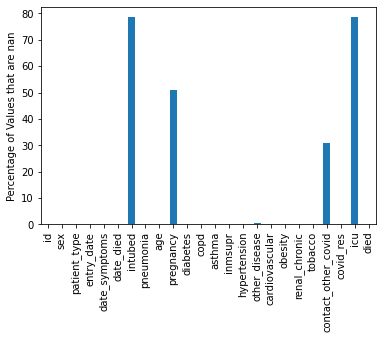

In [ ]:
missing_data = df_covid_pos.isnull().sum() * 100 / len(df)
missing_data.plot.bar()
plt.ylabel("Percentage of Values that are nan")

# Data Prep for predicting probability of death

In [ ]:
# Remove certain features (non-dv candidates)
df_covid_pos_columns_removed = df_covid_pos.drop(['id', 'patient_type', 'date_symptoms','entry_date', 'date_died', 'intubed', 'icu'], axis=1)
print("Observations before na removal = {}".format(df_covid_pos_columns_removed.shape[0]))

#Remove rows with NaN
df_covid_pos_columns_removed = df_covid_pos_columns_removed.dropna()
print("Observations after na removal = {}".format(df_covid_pos_columns_removed.shape[0]))

#Remove dv and assign dv
y = df_covid_pos_columns_removed.died.tolist()
df_covid_pos_columns_removed = df_covid_pos_columns_removed.drop(['died'], axis = 1)

#Create design matrix
print("Model Predictors = {}".format(df_covid_pos_columns_removed.columns))
X = df_covid_pos_columns_removed.to_numpy()

Observations before na removal = 566602
Observations after na removal = 190430
Model Predictors = Index(['sex', 'pneumonia', 'age', 'pregnancy', 'diabetes', 'copd', 'asthma',
       'inmsupr', 'hypertension', 'other_disease', 'cardiovascular', 'obesity',
       'renal_chronic', 'tobacco', 'contact_other_covid', 'covid_res'],
      dtype='object')


# Look to see if there is a class imbalance

In [ ]:
_, counts = np.unique(y, return_counts=True)
print(counts)

[185849   4581]


# Split data into train test split

In [ ]:
#Check and make sure the number of rows in X match that in y
print("nrow X = {}".format(X.shape[0]))
print("nrow y = {}".format(len(y)))

nrow X = 190430
nrow y = 190430


In [ ]:
seed = 7  #set random seed
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, #test_size (refer to the instructions for the assignment)
                                                    random_state = seed, #seed the random generator for reproducibilty
                                                    stratify = y)

# Model Training and Evaluation 

# Simulating more dead training instances

### Create function that simulates more instances of dead label

In [ ]:
#Create a function that randomly samples from each attribute (Based on distribution of those who died)
def random_label_generation(y_train, X_train, feature_names):
    new_training_instances = dict() #Initialize dictionary object
    output_train_array = np.array(y_train) #convert y_train to numpy array (Will allow for indexing )
    unique, unique_counts = np.unique(output_train_array, return_counts = True) #count number of labels
    min_label = unique[unique_counts == np.min(unique_counts)] #Finds the label with the smallest number of instances
    input_train_matrix = X_train[output_train_array == min_label ,:] #Take only the rows that belong to the smallest label
    number_instances_to_sample = np.max(unique_counts) - np.min(unique_counts) #Calculate the difference that needs to be accounted for
    #Loop through and sample from each feature number_instances_to_sample times
    for feature in range(len(feature_names)):
        new_training_instances[feature_names[feature]] = np.random.choice(input_train_matrix[:, feature], number_instances_to_sample, replace = True)
    return(new_training_instances)

### Check that the number of dead instances match that of the number of alive instances

In [ ]:
new_traning_instances = random_label_generation(y_train, X_train, df_covid_pos_columns_removed.columns)
new_traning_instances = pd.DataFrame(new_traning_instances).to_numpy()

#Check and make sure the number of death training instances match the number of alive training instances
diff_in_instances = (X_train[np.array(y_train) == 1 ,:].shape[0] +  new_traning_instances.shape[0]) - X_train[np.array(y_train) == 0 ,:].shape[0]#Take only the rows that belong to the smallest label
print("Number of instances for those who died - Number of instances for those who survived = {}".format(diff_in_instances))

Number of instances for those who died - Number of instances for those who survived = 0


In [ ]:
# Add new training instances and labels to X_trian and y_train
X_train_new = np.vstack((X_train, new_traning_instances)) #Combine old predictor instances with new
y_train_new = list(y_train) + list(np.ones(new_traning_instances.shape[0]).astype(int)) #Combine new labels

# Logistic Regression with newly simulated instances (Prototype model)

Logistic Accuracy = 0.9066848710812372


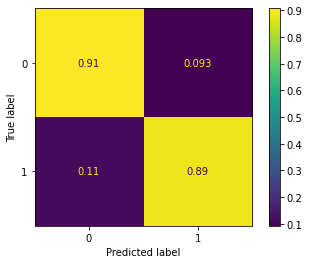

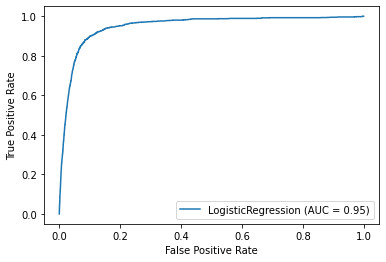

In [ ]:
#Fit/train model
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_new, y_train_new)

#Test model
y_pred = logisticRegr.predict(X_test)
logisticRegr_accuracy = accuracy_score(y_test, y_pred)

#Evaluate model
print('Logistic Accuracy = {}'.format(logisticRegr_accuracy))
plot_confusion_matrix(logisticRegr, X_test, y_test, normalize='true')
plot_roc_curve(logisticRegr, X_test, y_test)

# **DFFNN**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

# scale the data

X = sc.fit_transform(X_train_new)
X_test = sc.fit_transform(X_test)
y = np.array(y_train_new)
y_test = np.array(y_test)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [ ]:
#Build a sequential model with (tried 1/2/3 layers)

ffnn_model = Sequential()
ffnn_model.add(Dense(400, activation='softmax', input_shape=(X.shape[1],))) 

#Add the first hidden layer with a suitable number of units/neurons and the 'relu' activation function
ffnn_model.add(Dense(100, activation='relu'))
#Add the second hidden layer with a suitable number of units/neurons and the 'relu' activation function
#Add the output layer
ffnn_model.add(Dense(1, activation='sigmoid'))

my_optimizer = Adam(lr=0.00005)

ffnn_model.compile(optimizer= my_optimizer, #state the optimize
                   loss= 'binary_crossentropy',      # state the loss function
                   metrics= [metrics.binary_accuracy]   # state the metric
                  )

ffnn_history = ffnn_model.fit(X, y, 
                              validation_split= 0.3, 
                              epochs= 300, # state the number of epochs (you may need to run the model a few times to find a suitable value)
                              batch_size= 128 , # state the number of observations to use in each batch
                              verbose=2)

Epoch 1/300
1423/1423 - 4s - loss: 0.6363 - binary_accuracy: 0.7134 - val_loss: 1.1163 - val_binary_accuracy: 0.0000e+00
Epoch 2/300
1423/1423 - 4s - loss: 0.5594 - binary_accuracy: 0.7143 - val_loss: 1.0108 - val_binary_accuracy: 0.0000e+00
Epoch 3/300
1423/1423 - 4s - loss: 0.4086 - binary_accuracy: 0.8024 - val_loss: 0.6132 - val_binary_accuracy: 0.7165
Epoch 4/300
1423/1423 - 4s - loss: 0.2900 - binary_accuracy: 0.8888 - val_loss: 0.4597 - val_binary_accuracy: 0.8050
Epoch 5/300
1423/1423 - 4s - loss: 0.2510 - binary_accuracy: 0.8996 - val_loss: 0.4023 - val_binary_accuracy: 0.8450
Epoch 6/300
1423/1423 - 4s - loss: 0.2382 - binary_accuracy: 0.9071 - val_loss: 0.3881 - val_binary_accuracy: 0.8576
Epoch 7/300
1423/1423 - 4s - loss: 0.2331 - binary_accuracy: 0.9085 - val_loss: 0.4058 - val_binary_accuracy: 0.8539
Epoch 8/300
1423/1423 - 4s - loss: 0.2306 - binary_accuracy: 0.9085 - val_loss: 0.3949 - val_binary_accuracy: 0.8581
Epoch 9/300
1423/1423 - 4s - loss: 0.2291 - binary_accur

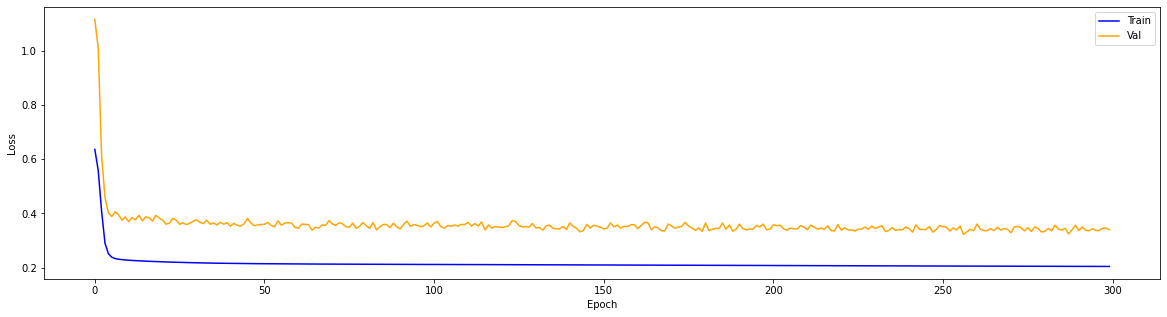

In [ ]:
    plt.figure(figsize=(20,5))
    plt.plot(ffnn_history.history['loss'], 'b', ffnn_history.history['val_loss'], 'orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

# `FFNN Accuracy`

In [ ]:
y_pred = ffnn_model.predict(X_test)

In [ ]:
y_pred

array([[0.03079489],
       [0.00104296],
       [0.00440049],
       ...,
       [0.1922845 ],
       [0.04944029],
       [0.01045141]], dtype=float32)

In [ ]:
_, accuracy = ffnn_model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1786/1786 [==============================] - 2s 1ms/step - loss: 0.1602 - binary_accuracy: 0.9304
Accuracy: 93.04


# `Investigate Confusion Maxtrix and Adjusting Threshold`

In [ ]:
y_score = y_pred > 0.5 #set threshold at 0.5

In [ ]:
cm = confusion_matrix(y_test,y_score,labels=[0,1],normalize='true')

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_score).ravel()
(tn, fp, fn, tp)

(52002, 3753, 225, 1149)

In [ ]:
y_higher =  y_pred > 0.7 #set threshold at 0.7
tn, fp, fn, tp = confusion_matrix(y_test, y_higher).ravel()
(tn, fp, fn, tp)

(53216, 2539, 376, 998)

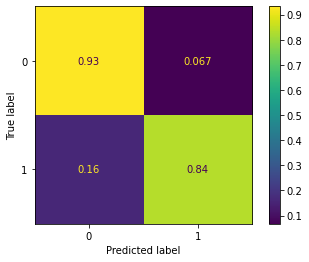

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp = disp.plot(include_values=True)

plt.show()
#threshold = 0.5

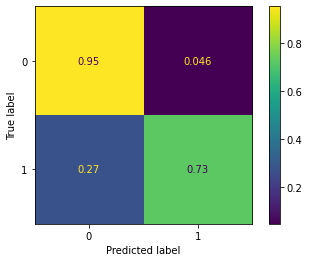

In [ ]:
cm_h = confusion_matrix(y_test,y_higher,labels=[0,1],normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_h,display_labels=[0,1])
disp = disp.plot(include_values=True)

plt.show()
#threshold = 0.7

In [ ]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(0,2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:], y_pred[:])
    roc_auc[i] = auc(fpr[i], tpr[i])

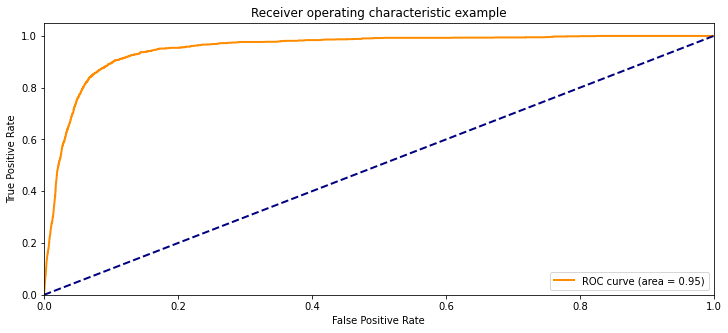

In [ ]:
plt.figure(figsize=(12,5))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Adaboost

In [ ]:
abm = AdaBoostClassifier()
abm.fit(X_train_new, y_train_new)
print(abm.score(X_test, y_test))

0.9154369934709167


### Adaboost evaluation

Adaboost Accuracy = 0.9154369934709167


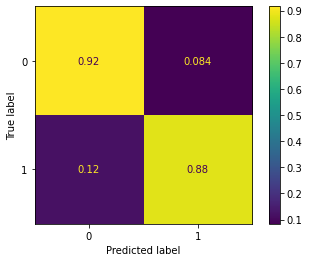

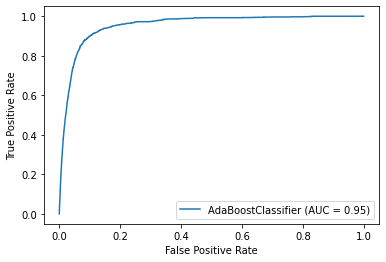

In [ ]:
print('Adaboost Accuracy = {}'.format(abm.score(X_test, y_test)))
plot_confusion_matrix(abm, X_test, y_test, normalize='true')
plot_roc_curve(abm, X_test, y_test)